# Unet TF for Inferentia (NeuronSDK)
In this example, you'll see how to compile a public implementation of an Unet Model created for TF2.x to Inferentia (inf1 instances)

In [ ]:
!pip install tensorflow-neuron[cc] "protobuf<4"

### Get Unet for TF2 from Github

In [ ]:
!git clone https://github.com/jakeret/unet

### Import common libraries

In [1]:
import sys
sys.path.insert(0,'unet/src')
import tensorflow as tf
import tensorflow.neuron as tfn
import matplotlib.pyplot as plt
import numpy as np
import unet
from unet import utils
from unet.datasets import circles
tf.__version__

'2.5.2'

### Prepare and train the model

In [2]:
unet_model = unet.build_model(channels=circles.channels,
                              num_classes=circles.classes,
                              layer_depth=3,
                              filters_root=16)
unet.finalize_model(unet_model)
train_dataset, validation_dataset = circles.load_data(100, nx=200, ny=200, splits=(0.7, 0.3))
trainer = unet.Trainer(checkpoint_callback=False)

In [3]:
trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=5,
            batch_size=1)
unet_model.save('unet_circles.h5')

Epoch 1/5
70/70 [==============================] - 8s 97ms/step - loss: 0.2879 - categorical_crossentropy: 0.2879 - categorical_accuracy: 0.9514 - mean_iou: 0.4381 - dice_coefficient: 0.8445 - auc: 0.9519 - val_loss: 0.1863 - val_categorical_crossentropy: 0.1863 - val_categorical_accuracy: 0.9531 - val_mean_iou: 0.4680 - val_dice_coefficient: 0.8476 - val_auc: 0.9930
Epoch 2/5
70/70 [==============================] - 6s 91ms/step - loss: 0.1235 - categorical_crossentropy: 0.1235 - categorical_accuracy: 0.9542 - mean_iou: 0.5605 - dice_coefficient: 0.9355 - auc: 0.9891 - val_loss: 0.1076 - val_categorical_crossentropy: 0.1076 - val_categorical_accuracy: 0.9531 - val_mean_iou: 0.5779 - val_dice_coefficient: 0.9514 - val_auc: 0.9907
Epoch 3/5
70/70 [==============================] - 6s 90ms/step - loss: 0.1070 - categorical_crossentropy: 0.1070 - categorical_accuracy: 0.9542 - mean_iou: 0.5928 - dice_coefficient: 0.9462 - auc: 0.9910 - val_loss: 0.1338 - val_categorical_crossentropy: 0.13

### Run the model and plot the results

In [4]:
prediction = unet_model.predict(validation_dataset.batch(batch_size=3))

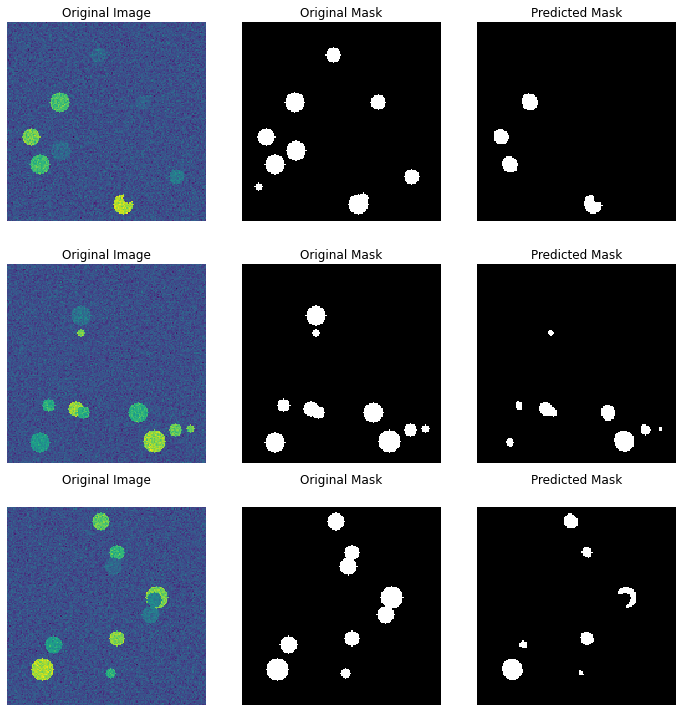

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()

### Simple benchmark on CPU

In [6]:
x = validation_dataset.batch(batch_size=1)
x = next(iter(x))[0]

In [7]:
# test with CPU
%timeit unet_model(x)

18.9 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Tracing the model with NeuronSDK

In [8]:
import os

# https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html
os.environ["NEURON_CC_FLAGS"] = "--verbose=DEBUG --neuroncore-pipeline-cores=1 --workdir=logs/ --dynamic-batch-size"
neuron_model = tfn.trace(unet_model, x)
neuron_model.save('unet_circles_neuron')

INFO:tensorflow:Assets written to: unet_circles_neuron/assets


### Load the model from disk to see if it worked

In [9]:
neuron_model = tf.saved_model.load('unet_circles_neuron')

### Simple benchmark on 1 core of the Inf1 instance

In [10]:
y = neuron_model(x) # warmup
%timeit neuron_model(x)

5.87 ms ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
